## In this test, we recreate the results from the FiO experiment to verify the simulations. 

In [8]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.light_sources import light_source
from trajectree.fock_optics.devices import global_phase
from trajectree.fock_optics.measurement import rotate_and_measure
from trajectree.fock_optics.outputs import read_quantum_state, plot_coincidences
from trajectree.trajectory import trajectory_evaluator, quantum_channel


import time
from scipy import sparse as sp
import numpy as np

In [ ]:
# params
trunc = 4
N = trunc+1
error_tolerance = 1e-12

mean_photon_num = 0.0597
efficiency = 1

idler_angles = (0, np.pi/2, np.pi, 3*np.pi/2)
signal_angles = np.linspace(0, 2*np.pi, 30)

In [ ]:

num_modes = 8
# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
# psi = new_ls(N, mean_photon_num, error_tolerance) 

read_quantum_state(psi, N, num_states = 2)

Corresponding Basis terms:
0H0V_B 0H0V_A - 0 - [0.94366331+0.j]
1H0V_B 1H0V_A - 26 - [-0.22398172+0.j]
2H0V_B 2H0V_A - 52 - [0.05316476+0.j]
3H0V_B 3H0V_A - 78 - [-0.01259794+0.j]
4H0V_B 4H0V_A - 104 - [0.00314041+0.j]
0H1V_B 0H1V_A - 130 - [-0.22398172+0.j]
1H1V_B 1H1V_A - 156 - [0.05316283+0.j]
2H1V_B 2H1V_A - 182 - [-0.01261884+0.j]
3H1V_B 3H1V_A - 208 - [0.00299017+0.j]
4H1V_B 4H1V_A - 234 - [-0.00074539+0.j]
0H2V_B 0H2V_A - 260 - [0.05316476+0.j]
1H2V_B 1H2V_A - 286 - [-0.01261884+0.j]
2H2V_B 2H2V_A - 312 - [0.00299523+0.j]
3H2V_B 3H2V_A - 338 - [-0.00070975+0.j]
4H2V_B 4H2V_A - 364 - [0.00017693+0.j]
0H3V_B 0H3V_A - 390 - [-0.01259794+0.j]
1H3V_B 1H3V_A - 416 - [0.00299017+0.j]
2H3V_B 2H3V_A - 442 - [-0.00070975+0.j]
3H3V_B 3H3V_A - 468 - [0.00016818+0.j]
4H3V_B 4H3V_A - 494 - [-4.19246e-05+0.j]
0H4V_B 0H4V_A - 520 - [0.00314041+0.j]
1H4V_B 1H4V_A - 546 - [-0.00074539+0.j]
2H4V_B 2H4V_A - 572 - [0.00017693+0.j]
3H4V_B 3H4V_A - 598 - [-4.19246e-05+0.j]
4H4V_B 4H4V_A - 624 - [1.045

In [46]:
fringes = {}

for idler_angle in idler_angles:
    coincidence_prob = []
    for signal_angle in signal_angles:

        quantum_channel_list = []

        phase_flip_ops = [sp.csr_matrix(global_phase(0, N, return_unitary = True, site1 = 0, site2 = 1, total_sites = 2))]
        quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1), phase_flip_ops), name = "first_kraus"))

        PA_MPOs = rotate_and_measure(None, N, psi.site_tags, num_modes, efficiency, error_tolerance, [idler_angle], [signal_angle], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {1:(0,2), 0:()}, return_MPOs = True)
        quantum_channel_list.extend([quantum_channel(N = N, num_modes = 4, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in PA_MPOs])

        evaluator = trajectory_evaluator(quantum_channel_list)

        psi_iter = evaluator.perform_simulation(psi, error_tolerance, normalize = False)
        coincidence_prob.append(psi_iter.normalize())
    
    fringes[idler_angle] = coincidence_prob

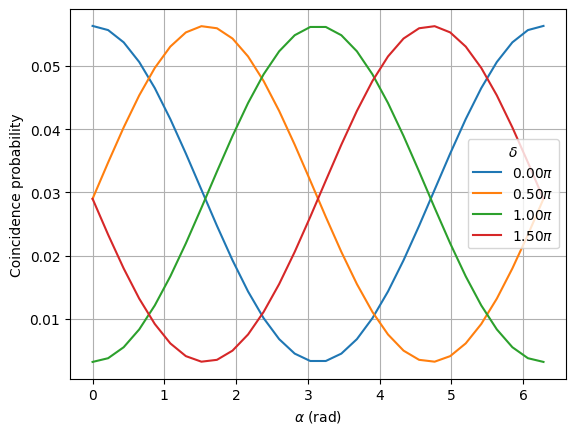

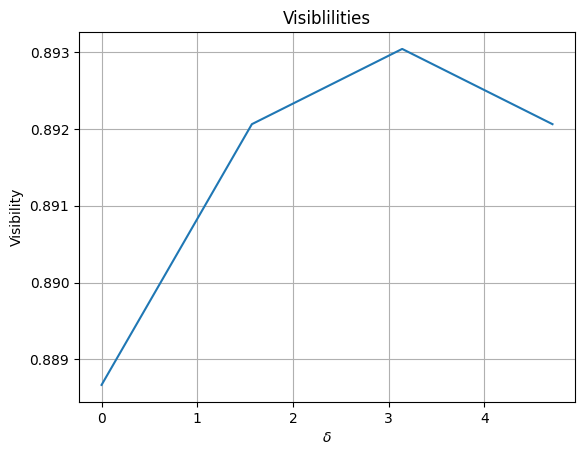

In [47]:
plot_coincidences(list(fringes.values()), list(fringes.keys()), signal_angles)